Implement and test the 3 conditions of Schaal14 for shock detection

In [1]:
import Utilities.prelude
import pickle 
import numpy as np
import matplotlib.pyplot as plt
import math
import k3match
from Utilities.operators import make_tree, calc_grad, calc_div

In [2]:
gamma = 5/3
mach_min = 1.3
save = False
snap = '100'
folder = 'sedov'
path = f'{folder}/{snap}'

In [3]:
def temperature_bump(mach, gamma):
    """ T_post/ T_pre shock according to RH conditions."""
    Tbump =  (mach**2 * (gamma-1) + 2) * (2 * gamma * mach**2 - (gamma-1)) / (mach**2 * (gamma+1)**2)
    return Tbump

def pressure_bump(mach, gamma):
    """ P_post/ P_pre shock according to RH conditions."""
    Pbump = (2 * gamma * mach**2 - (gamma-1)) / (gamma+1)
    return Pbump

def search_delta(X, Y, Z, point, dim_cell):
    x_point = point[0]
    y_point = point[1]
    z_point = point[2]

    _, _ , dist= k3match.cartesian(X, Y, Z, x_point, y_point, z_point, 2.5*dim_cell)
    delta = np.mean(dist)
    
    return delta

def shock_direction(sim_tree, X, Y, Z, Temp, point, delta):
    """ Find shock direction according eq.(5) by Schaal14 in the point of coordinates indices idx.
    Parameters
    -----------
    sim_tree: tree.
            Simulation points.
    X, Y, Z, Temp: arrays.
            Coordinates and temperature of the points of the tree.
    point: array.
            Starting point.
    delta: float.
            Step between 2 neighbours.
    Returns
    -----------
    grad: array.
        Gradient of temperature(vector of 3 components).
    ds: array.
        Shock direction (vector of 3 components).
    """
    grad = calc_grad(sim_tree, X, Y, Z, Temp, point, delta)
    magnitude = np.linalg.norm(grad)
    
    if np.logical_and(np.abs(grad[0])<1, np.logical_and(np.abs(grad[1])<1, np.abs(grad[2])<1)):
        ds = np.zeros(3)
    else:
        ds = - np.divide(grad,magnitude)
    return grad, ds
 
def find_prepost(sim_tree, X, Y, Z, point, ds, delta, direction):
    """
    Parameters
    -----------
    point: array.
        Starting point.
    ds: array (1x3)
        Shock direction.
    delta: float.
        Step to do to search.
    direction: str.
        Choose pre or post shock.
    Returns
    -----------
    new_point: array.
        Pre/post shock point
    """
    if direction == 'post':
        delta = - delta

    k = 1
    # check that you are not taking the same point as the one given
    distance = 0
    while distance == 0:
        new_point = point + k * delta * ds 
        _, idx  = sim_tree.query(new_point)
        check_point = np.array([X[idx], Y[idx], Z[idx]])
        distance = math.dist(point, check_point)
        k += 0.1

    return idx

def condition3(sim_tree, X, Y, Z, Press, Temp, point, ds, mach_min, gamma, delta):
    """ Last condition fot shock zone by Schaal14 .
    Parameters
    -----------
    sim_tree: tree.
            Simulation points.
    X, Y, Z, Press, Temp: arrays.
            Coordinates, pressure and temperature of the points of the tree.
    point: array.
            Starting point.
    ds: array (1x3)
        Shock direction.
    mach_min, gamma: floats.
                    Minimum mach number, adiabatic index.
    delta: float.
            Step between 2 neighbours.
    Returns
    -----------
    bool.
        If condition is satisfied or not.
    """
    # Find (the index in the tree of) the point in the pre/post shock region.
    idxpost = find_prepost(sim_tree, X, Y, Z, point, ds, delta, direction = 'post') 
    idxpre = find_prepost(sim_tree, X, Y, Z, point, ds, delta, direction = 'pre') 

    # Store data from the tree
    Tpost = Temp[idxpost]
    Ppost = Press[idxpost]
    Tpre = Temp[idxpre]
    Ppre = Press[idxpre]

    # Last condition fot shock zone by Schaal14
    delta_logT = np.log(Tpost) - np.log(Tpre)
    Tjump = temperature_bump(mach_min, gamma)
    Tjump = np.log(Tjump)
    ratioT = delta_logT / Tjump 
    delta_logP = np.log(Ppost)-np.log(Ppre)
    Pjump = pressure_bump(mach_min, gamma)
    Pjump = np.log(Pjump)
    ratioP = delta_logP / Pjump 
    
    if np.logical_and(ratioT >= 1, ratioP >= 1): 
        return True
    else:
        return False
    
def shock_zone(divv, gradT, gradrho, cond3, check_cond = '3'):
    """ Find the shock zone according conditions in Sec. 2.3.2 of Schaal14. 
    In order to test the code, with "check_con" you can decide if checking all or some of the conditions."""
    if check_cond == '1' or check_cond == '2':
        cond3 = True # so you don't check it
        if check_cond == '2':
            cond2 = np.dot(gradT, gradrho)
        else:
            cond2 = 10
    else:
        cond2 = np.dot(gradT, gradrho)

    if np.logical_and(divv<0, np.logical_and(cond2 > 0, cond3 == True)):
        return True
    else:
        return False

In [4]:
sim_tree, X, Y, Z, Vol, VX, VY, VZ, Den, Press, Temp = make_tree(path, snap, False)
dim_cell = (3*Vol/(4*np.pi))**(1/3)

all T=0, bro. Compute by myself!


In [21]:
shock_dirx = []
shock_diry = []
shock_dirz = []
X_shock1 = []
Y_shock1 = []
Z_shock1 = []
X_shock2 = []
Y_shock2 = []
Z_shock2 = []
X_shock = []
Y_shock = []
Z_shock = []
div_shock = []
T_shock = []
are_u_shock = np.zeros(len(X), dtype = bool)
x_who = []
y_who = []
z_who = []
idx_tree = []

masked = 0
gradTx = np.gradient(Temp, X)
gradTy = np.gradient(Temp, Y)
gradTz = np.gradient(Temp, Z)

gradDenx = np.gradient(Den, X)
gradDeny = np.gradient(Den, Y)
gradDenz = np.gradient(Den, Z)

divV = np.gradient(VX, X) + np.gradient(VY, Y) + np.gradient(VZ, Z)

for i in range(len(X)):
    # print(i)
    point = np.array([X[i],Y[i],Z[i]])

    if np.linalg.norm(point)>0.99:
        masked += 1
        are_u_shock[i] = False
        continue

    step_grad = 2*dim_cell[i]#search_delta(X, Y, Z, point, dim_cell[i])
    step_zone = step_grad
    gradT = np.array([gradTx[i], gradTy[i], gradTz[i]])
    modgradT = np.linalg.norm(gradT)

    # fondamentale!!
    if modgradT < 1e-8:
        print('gradT 0')
        are_u_shock[i] = False
        continue

    ds = - gradT / modgradT
    gradDen = np.array([gradDenx[i], gradDeny[i], gradDenz[i]])
    div_vel = divV[i]

    if math.isnan(np.linalg.norm(div_vel)):
        # non dovrebbe succedere per come prendi step in ds=2*max
        are_u_shock[i] = False
        print('nan in div_v')

    cond3 = condition3(sim_tree, X, Y, Z, Press, Temp, point, ds, mach_min, gamma, step_zone)
    shock1 = shock_zone(div_vel, gradT, gradDen, cond3, check_cond =  '1')
    shock2 = shock_zone(div_vel, gradT, gradDen, cond3, check_cond =  '2')
    shock = shock_zone(div_vel, gradT, gradDen, cond3, check_cond = '3')
    are_u_shock[i] = shock
    
    if shock1 == True:
        X_shock1.append(X[i])
        Y_shock1.append(Y[i])
        Z_shock1.append(Z[i])

    if shock2 == True:
        X_shock2.append(X[i])
        Y_shock2.append(Y[i])
        Z_shock2.append(Z[i])

    if shock == True:
        X_shock.append(X[i])
        Y_shock.append(Y[i])
        Z_shock.append(Z[i])
        shock_dirx.append(ds[0])
        shock_diry.append(ds[1])
        shock_dirz.append(ds[2])
        div_shock.append(div_vel)
        T_shock.append(Temp[i])
        idx_tree.append(i)

print(masked)      

gradT 0
gradT 0
gradT 0
gradT 0
gradT 0
gradT 0
gradT 0
gradT 0
gradT 0
gradT 0
gradT 0
gradT 0
gradT 0
gradT 0
gradT 0
gradT 0
gradT 0
gradT 0
gradT 0
gradT 0
gradT 0
gradT 0
gradT 0
gradT 0
gradT 0
gradT 0
gradT 0
gradT 0
gradT 0
gradT 0
gradT 0
gradT 0
gradT 0
gradT 0
gradT 0
gradT 0
gradT 0
gradT 0
gradT 0
gradT 0
gradT 0
gradT 0
gradT 0
gradT 0
gradT 0
gradT 0
gradT 0
gradT 0
gradT 0
gradT 0
gradT 0
gradT 0
gradT 0
gradT 0
gradT 0
gradT 0
gradT 0
gradT 0
gradT 0
gradT 0
gradT 0
gradT 0
gradT 0
gradT 0
gradT 0
gradT 0
gradT 0
gradT 0
gradT 0
gradT 0
gradT 0
gradT 0
gradT 0
gradT 0
gradT 0
gradT 0
gradT 0
gradT 0
gradT 0
gradT 0
gradT 0
gradT 0
gradT 0
gradT 0
gradT 0
gradT 0
gradT 0
gradT 0
gradT 0
gradT 0
gradT 0
gradT 0
gradT 0
gradT 0
gradT 0
gradT 0
gradT 0
gradT 0
gradT 0
gradT 0
gradT 0
gradT 0
gradT 0
gradT 0
gradT 0
gradT 0
gradT 0
gradT 0
gradT 0
gradT 0
gradT 0
gradT 0
gradT 0
gradT 0
gradT 0
gradT 0
gradT 0
gradT 0
gradT 0
gradT 0
gradT 0
gradT 0
gradT 0
gradT 0
gradT 0


In [22]:
X_shock = np.array(X_shock)
Y_shock = np.array(Y_shock)
Z_shock = np.array(Z_shock)

X_shock1 = np.array(X_shock1)
Y_shock1 = np.array(Y_shock1)
Z_shock1 = np.array(Z_shock1)

X_shock2 = np.array(X_shock2)
Y_shock2 = np.array(Y_shock2)
Z_shock2 = np.array(Z_shock2)

In [23]:
if save == True:
    with open(f'data/{snap}/shockzone_{snap}.txt', 'w') as file:
        file.write(f'# Coordinates of the points in the shock zone, mach_min = {mach_min} \n# X \n') 
        file.write(' '.join(map(str, X_shock)) + '\n')
        file.write('# Y \n') 
        file.write(' '.join(map(str, Y_shock)) + '\n')
        file.write('# Z \n') 
        file.write(' '.join(map(str, Z_shock)) + '\n')
        file.write('# div v \n') 
        file.write(' '.join(map(str, div_shock)) + '\n')
        file.write('# T \n') 
        file.write(' '.join(map(str, T_shock)) + '\n')
        file.write('# index in the tree \n') 
        file.write(' '.join(map(str, idx_tree)) + '\n')
        file.close()
    with open(f'data/{snap}/shockdir_{snap}.txt', 'w') as fileds:
        fileds.write('# shock x direction \n') 
        fileds.write(' '.join(map(str, shock_dirx)) + '\n')
        fileds.write('# shock y direction \n') 
        fileds.write(' '.join(map(str, shock_diry)) + '\n')
        fileds.write('# shock z direction \n') 
        fileds.write(' '.join(map(str, shock_dirz)) + '\n')
        fileds.close()

In [24]:
if save == True:
    with open(f'data/{snap}/shockbool_{snap}.pkl', 'wb') as filebool:
        pickle.dump(are_u_shock, filebool)

/var/folders/s6/3n46ppqn3jx7765w8c686c740000gn/T/ipykernel_69547/3229916677.py:10: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "ks" (-> color='k'). The keyword argument will take precedence.
  plt.plot(X_shock1[np.abs(Z_shock1)<lim0], Y_shock1[np.abs(Z_shock1)<lim0], 'ks', c = 'k', markerfacecolor='none', ms=8, markeredgecolor='coral', label = '1')
/var/folders/s6/3n46ppqn3jx7765w8c686c740000gn/T/ipykernel_69547/3229916677.py:11: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "ks" (-> color='k'). The keyword argument will take precedence.
  plt.plot(X_shock2[np.abs(Z_shock2)<lim0], Y_shock2[np.abs(Z_shock2)<lim0], 'ks', c = 'k', markerfacecolor='orange', ms=6, markeredgecolor='orange', label = '12')
/var/folders/s6/3n46ppqn3jx7765w8c686c740000gn/T/ipykernel_69547/3229916677.py:12: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "ks" (-> color='k').

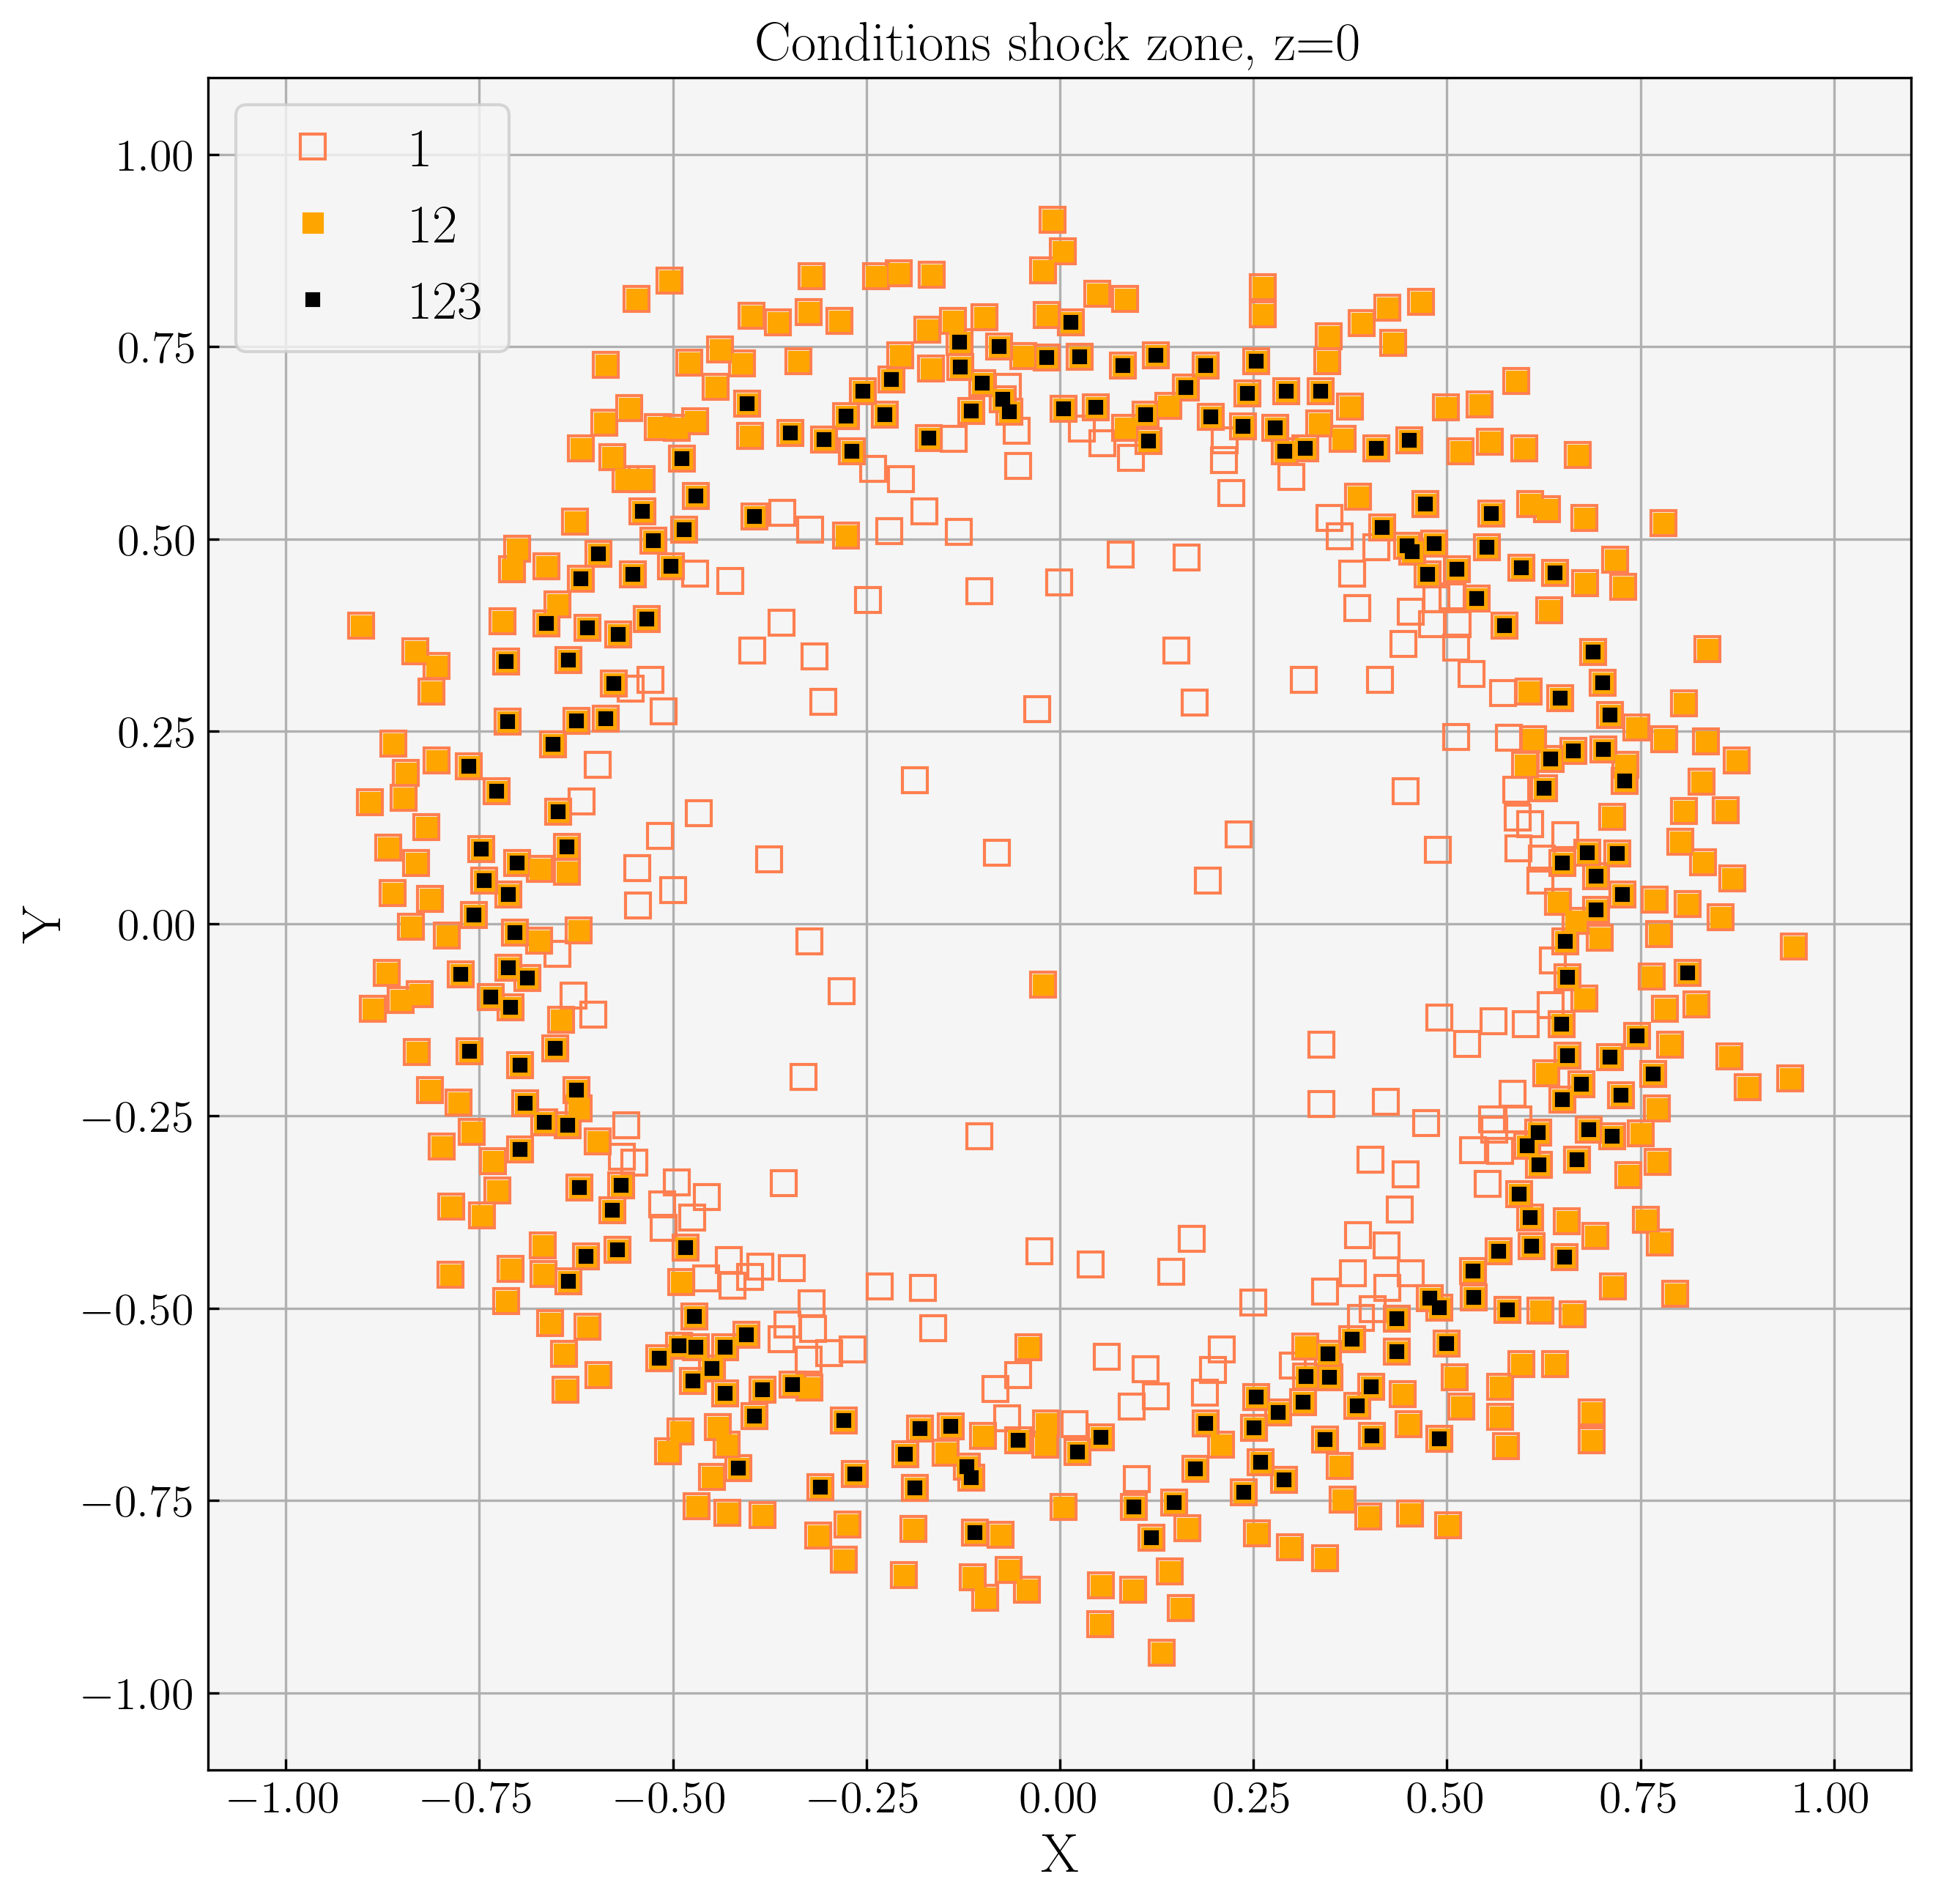

In [25]:
# Plot 3 conditions (cross section)

plt.figure(figsize=(10,10))
if folder == 'sedov':
    lim0 = 0.02
    plt.xlim(-1.1,1.1)
    plt.ylim(-1.1,1.1)
else:
    lim0 = 0.1
plt.plot(X_shock1[np.abs(Z_shock1)<lim0], Y_shock1[np.abs(Z_shock1)<lim0], 'ks', c = 'k', markerfacecolor='none', ms=8, markeredgecolor='coral', label = '1')
plt.plot(X_shock2[np.abs(Z_shock2)<lim0], Y_shock2[np.abs(Z_shock2)<lim0], 'ks', c = 'k', markerfacecolor='orange', ms=6, markeredgecolor='orange', label = '12')
plt.plot(X_shock[np.abs(Z_shock)<lim0], Y_shock[np.abs(Z_shock)<lim0], 'ks', c = 'k', markerfacecolor='k', ms=4, markeredgecolor='k', label = '123')
plt.xlabel('X', fontsize = 18)
plt.ylabel('Y', fontsize = 18)
plt.legend(loc = 'upper left', fontsize = 18)
plt.grid()
plt.title(r'Conditions shock zone, z=0', fontsize = 18)
if save:    
    plt.savefig(f'Figs/{snap}/3XYshockzone_conditions_{snap}.png')
plt.show()

/var/folders/s6/3n46ppqn3jx7765w8c686c740000gn/T/ipykernel_69547/3732794845.py:8: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "ks" (-> color='k'). The keyword argument will take precedence.
  plt.plot(Y_shock1[np.abs(X_shock1)<lim0], Z_shock1[np.abs(X_shock1)<lim0], 'ks', c = 'k', markerfacecolor='none', ms=8, markeredgecolor='b', label = '1')
/var/folders/s6/3n46ppqn3jx7765w8c686c740000gn/T/ipykernel_69547/3732794845.py:9: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "ks" (-> color='k'). The keyword argument will take precedence.
  plt.plot(Y_shock2[np.abs(X_shock2)<lim0], Z_shock2[np.abs(X_shock2)<lim0], 'ks', c = 'k', markerfacecolor='turquoise', ms=6, markeredgecolor='turquoise', label = '12')
/var/folders/s6/3n46ppqn3jx7765w8c686c740000gn/T/ipykernel_69547/3732794845.py:10: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "ks" (-> color='k').

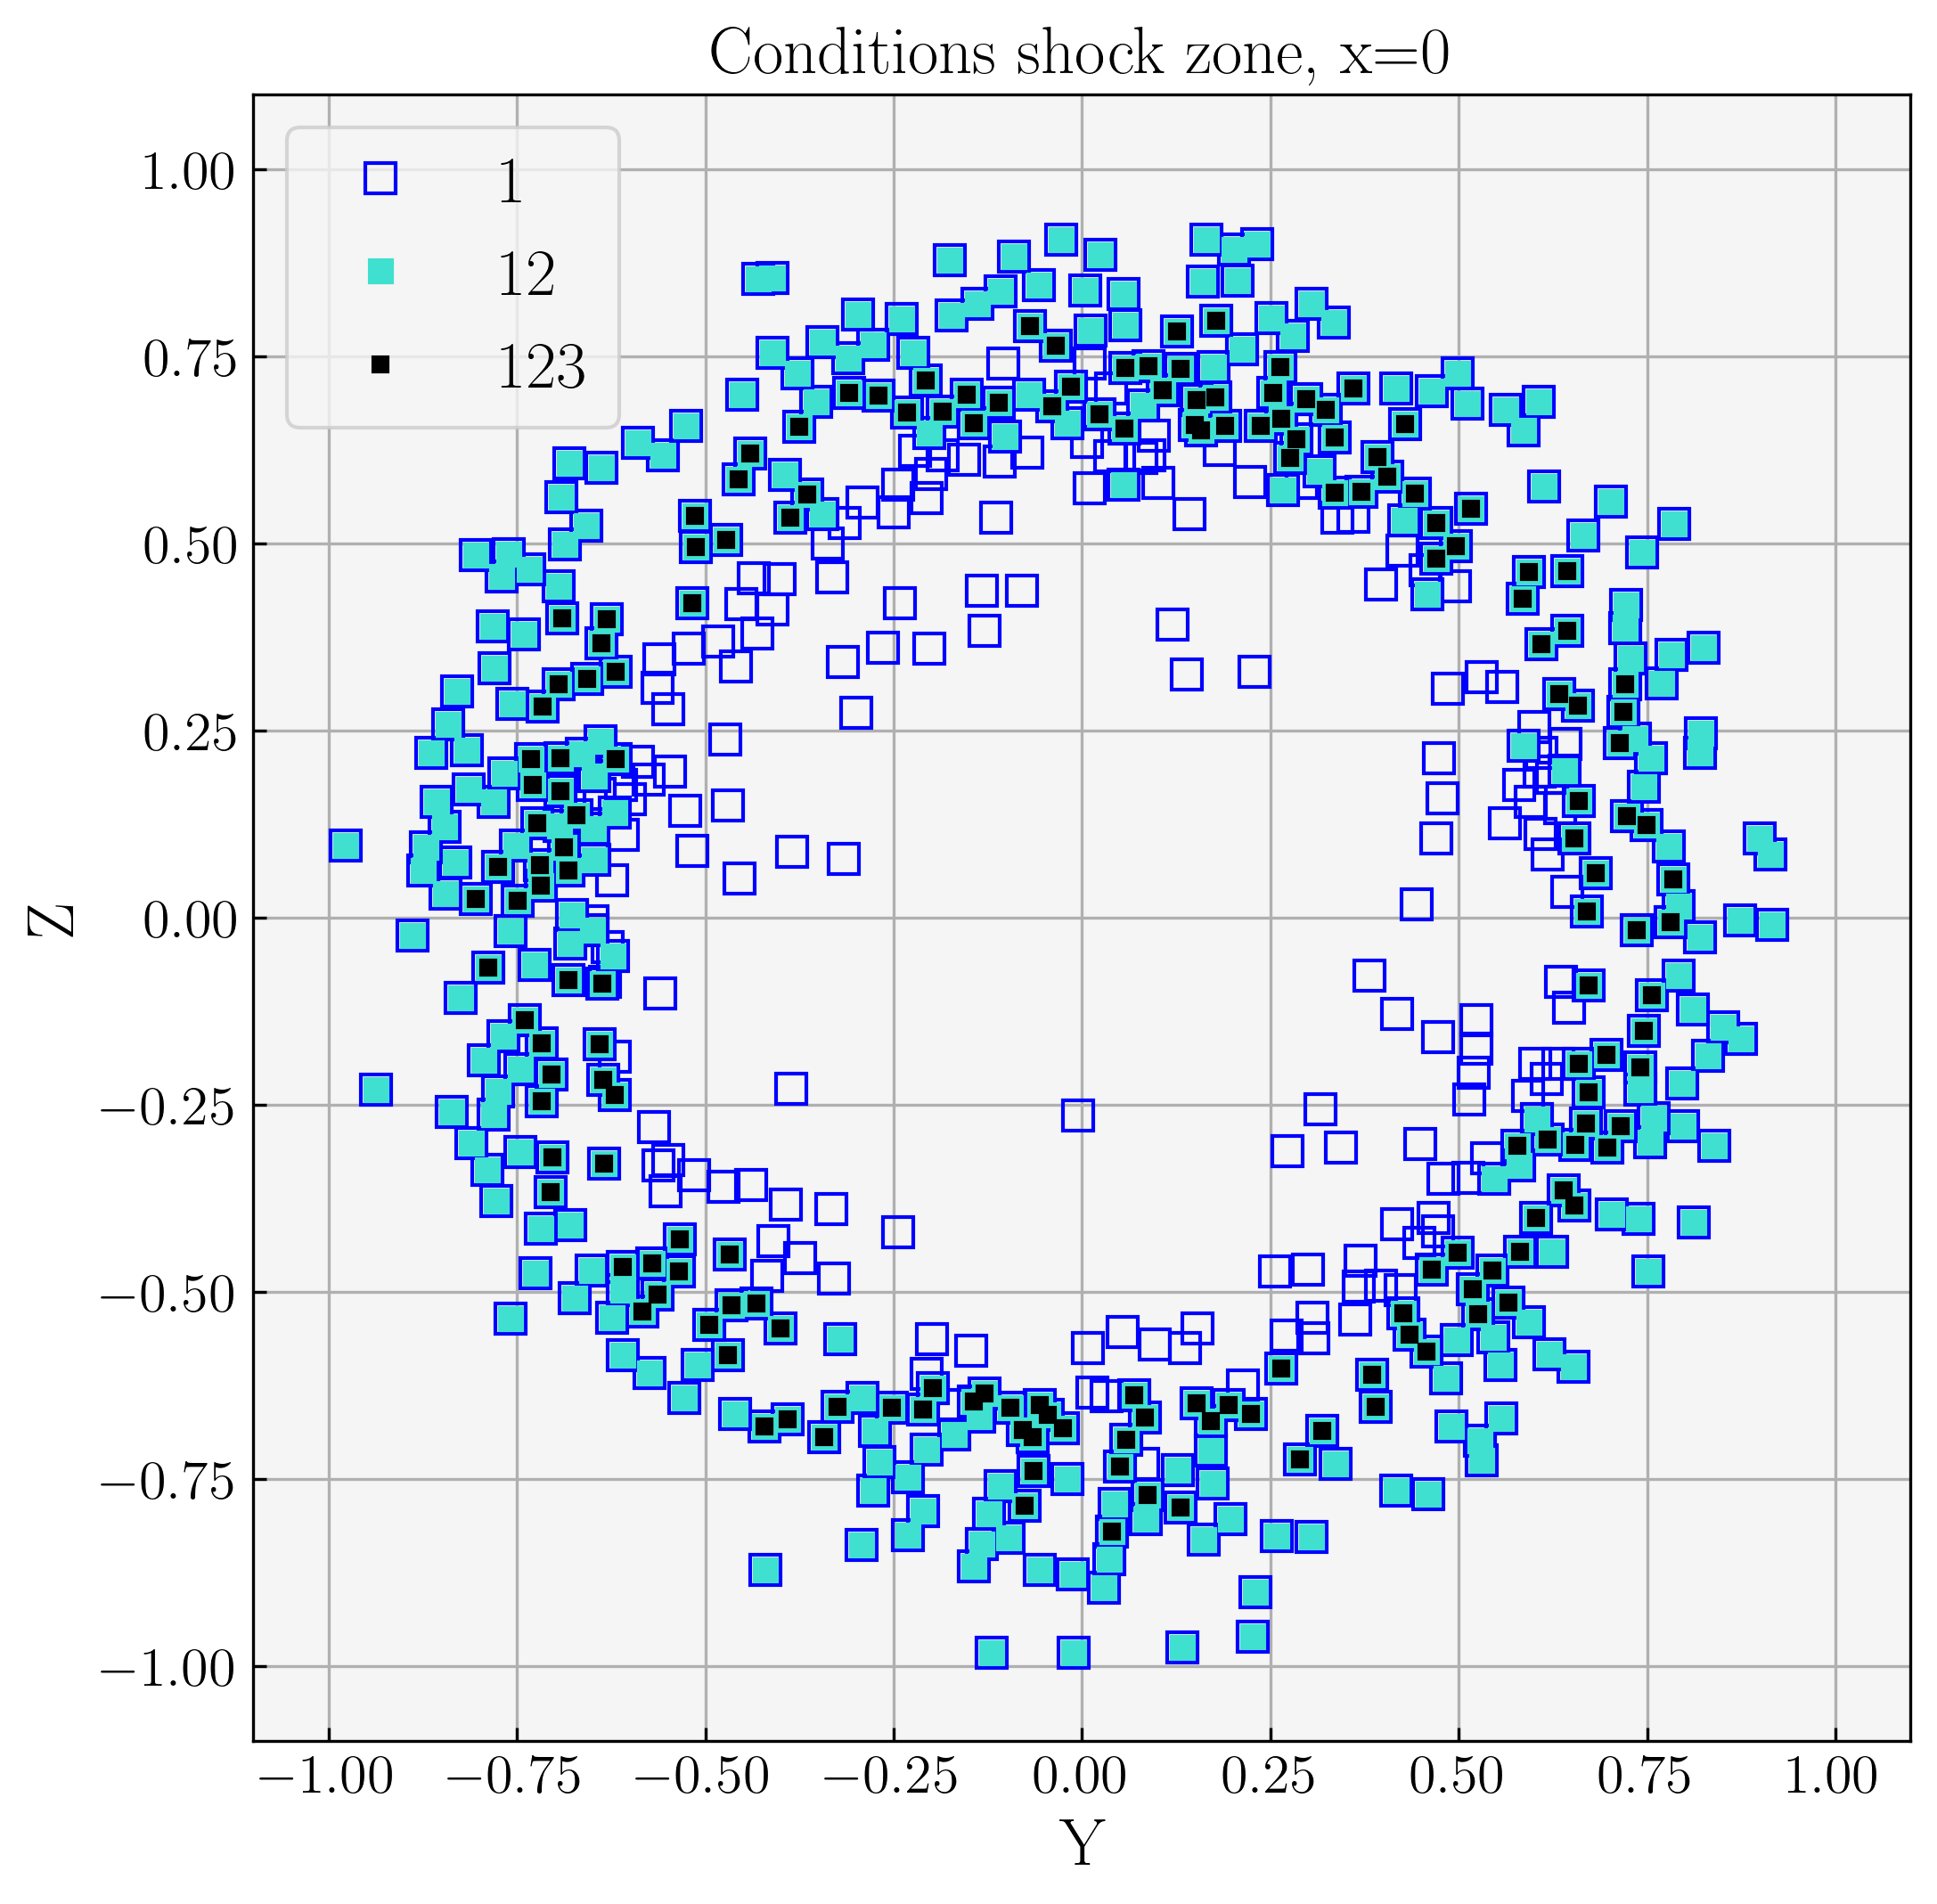

In [26]:
plt.figure(figsize=(8,8))
if folder == 'sedov':
    lim0 = 0.02
    plt.xlim(-1.1,1.1)
    plt.ylim(-1.1,1.1)
else:
    lim0 = 0.1
plt.plot(Y_shock1[np.abs(X_shock1)<lim0], Z_shock1[np.abs(X_shock1)<lim0], 'ks', c = 'k', markerfacecolor='none', ms=8, markeredgecolor='b', label = '1')
plt.plot(Y_shock2[np.abs(X_shock2)<lim0], Z_shock2[np.abs(X_shock2)<lim0], 'ks', c = 'k', markerfacecolor='turquoise', ms=6, markeredgecolor='turquoise', label = '12')
plt.plot(Y_shock[np.abs(X_shock)<lim0], Z_shock[np.abs(X_shock)<lim0], 'ks', c = 'k', markerfacecolor='k', ms=4, markeredgecolor='k', label = '123')
plt.xlabel('Y', fontsize = 18)
plt.ylabel('Z', fontsize = 18)
plt.legend(loc = 'upper left', fontsize = 18)
plt.grid()
plt.title(r'Conditions shock zone, x=0', fontsize = 18)
if save:    
    plt.savefig(f'Figs/{snap}/3YZshockzone_conditions_{snap}.png')
plt.show()

/var/folders/s6/3n46ppqn3jx7765w8c686c740000gn/T/ipykernel_69547/808927983.py:8: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "ks" (-> color='k'). The keyword argument will take precedence.
  plt.plot(X_shock1[np.abs(Y_shock1)<lim0], Z_shock1[np.abs(Y_shock1)<lim0], 'ks', c = 'k', markerfacecolor='none', ms=8, markeredgecolor='purple', label = '1')
/var/folders/s6/3n46ppqn3jx7765w8c686c740000gn/T/ipykernel_69547/808927983.py:9: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "ks" (-> color='k'). The keyword argument will take precedence.
  plt.plot(X_shock2[np.abs(Y_shock2)<lim0], Z_shock2[np.abs(Y_shock2)<lim0], 'ks', c = 'k', markerfacecolor='magenta', ms=6, markeredgecolor='magenta', label = '12')
/var/folders/s6/3n46ppqn3jx7765w8c686c740000gn/T/ipykernel_69547/808927983.py:10: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "ks" (-> color='k'). T

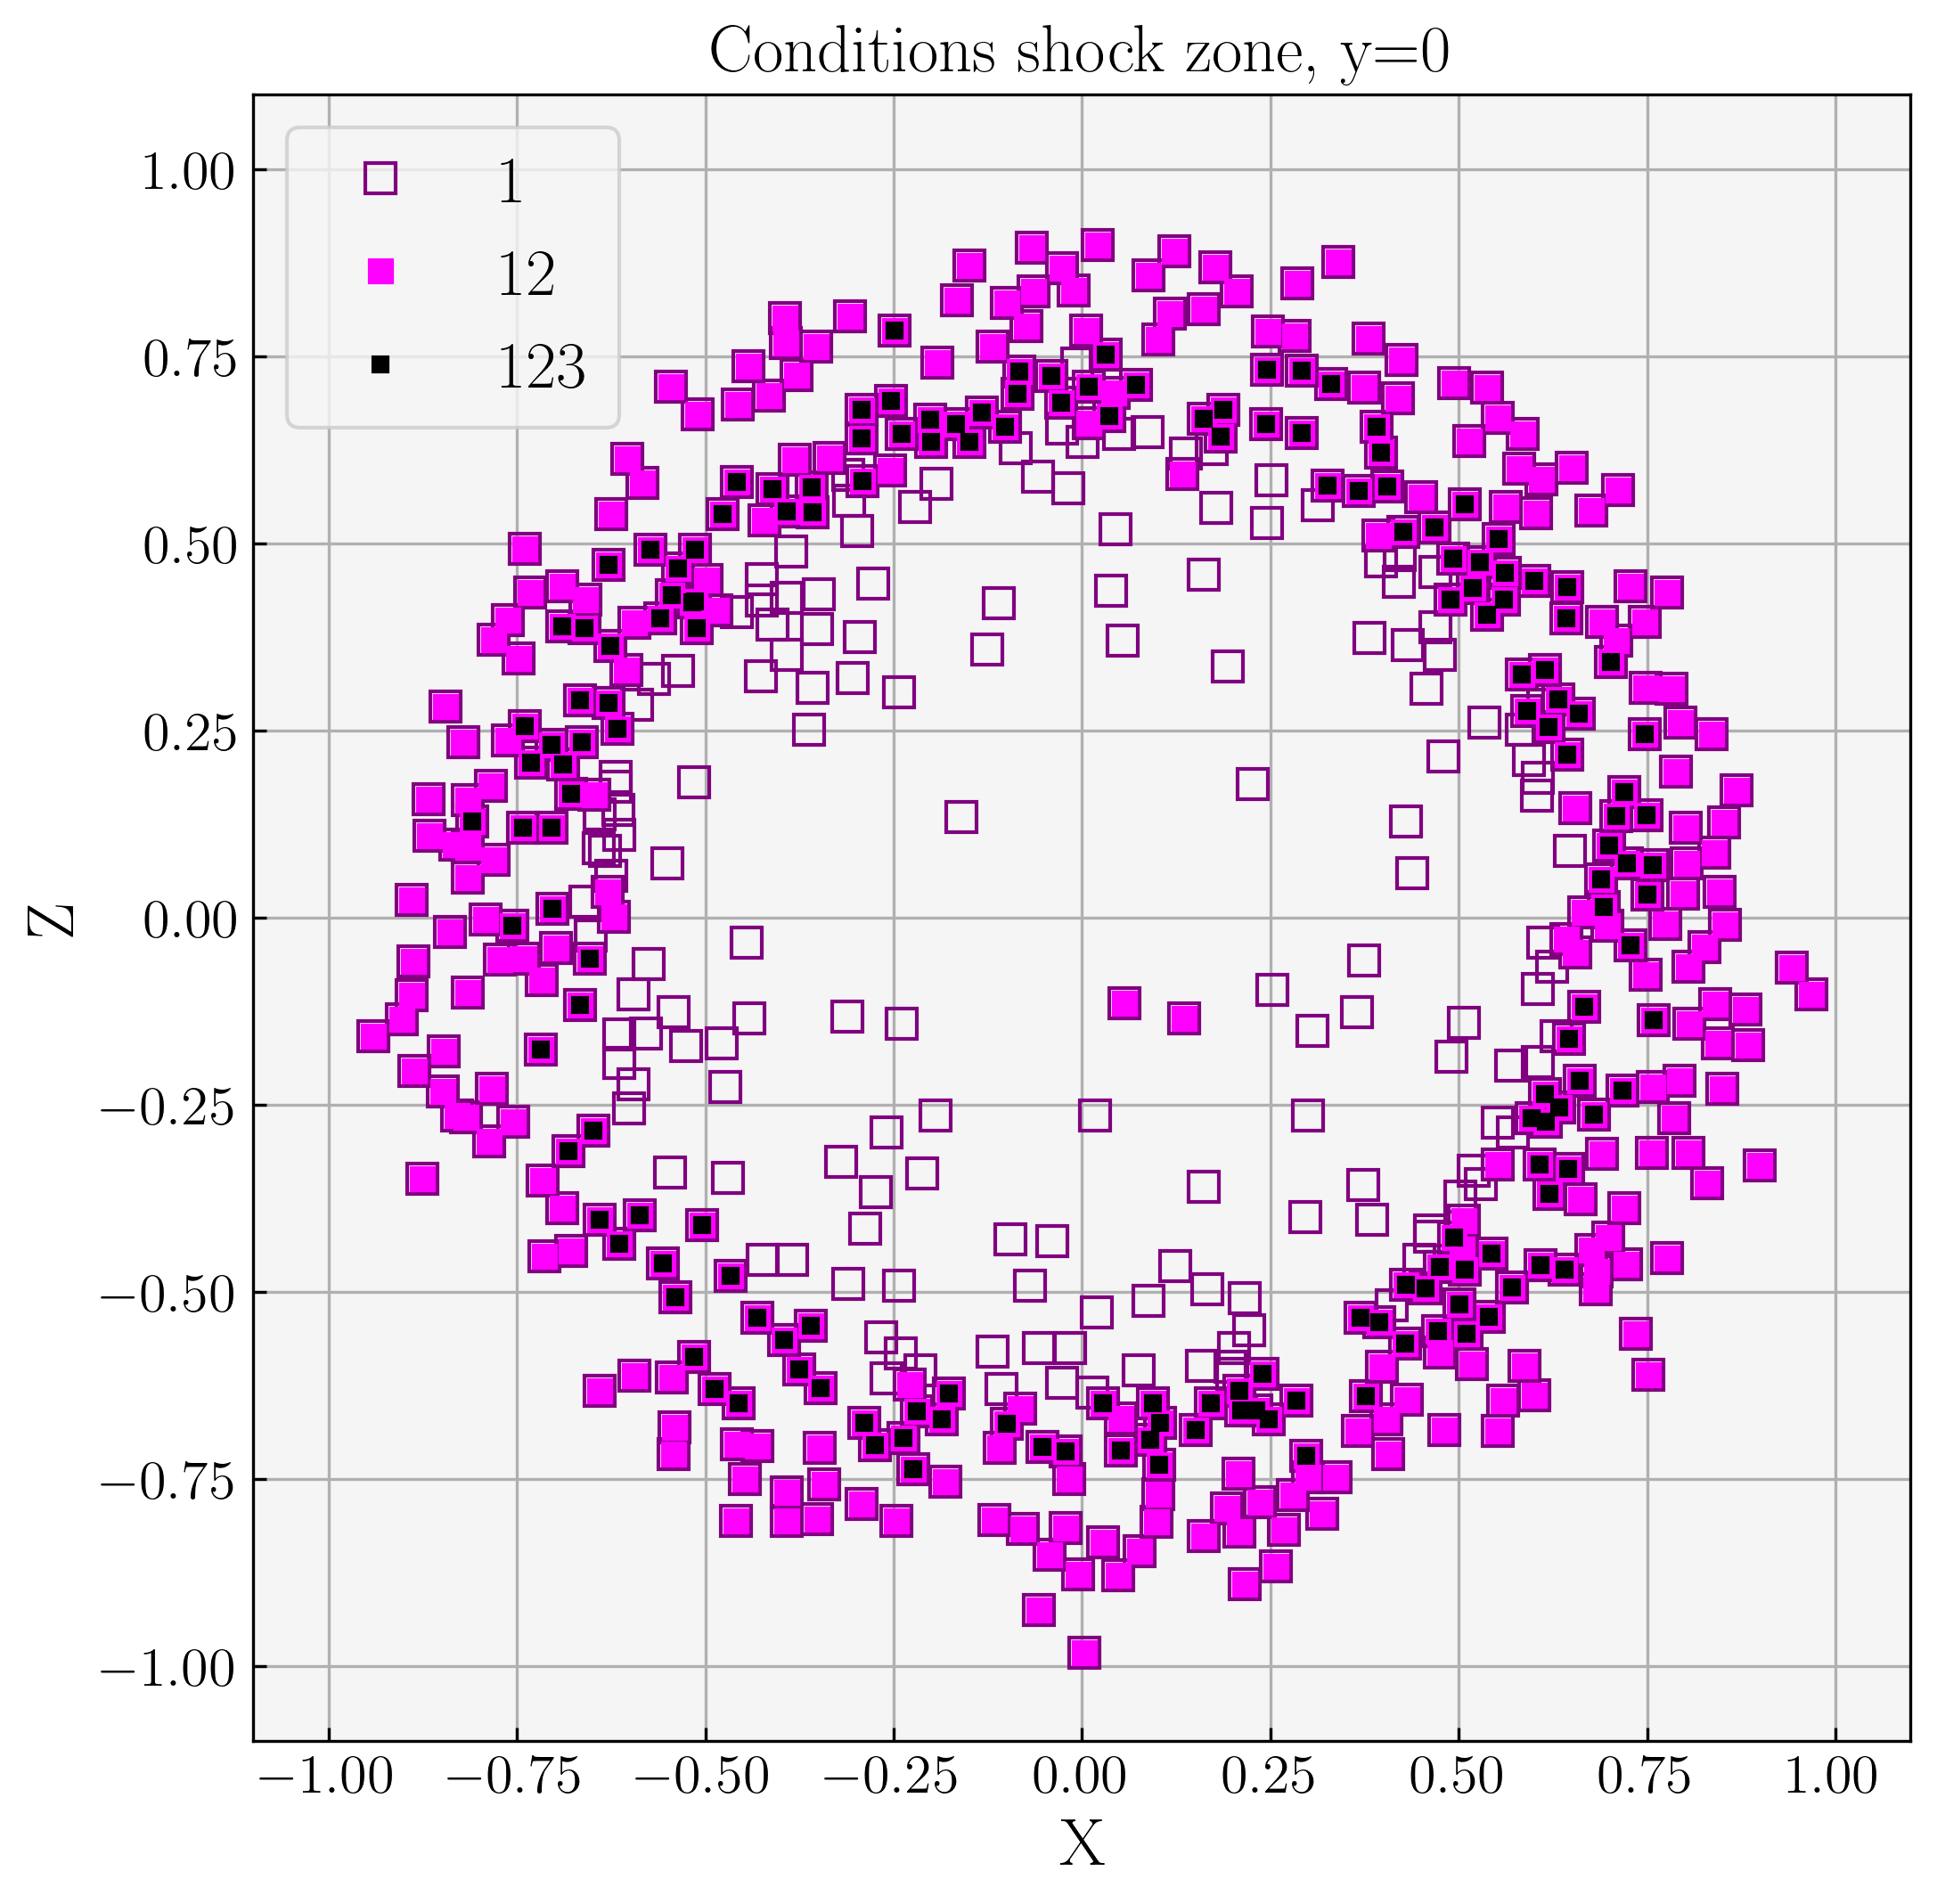

In [27]:
plt.figure(figsize=(8,8))
if folder == 'sedov':
    lim0 = 0.02
    plt.xlim(-1.1,1.1)
    plt.ylim(-1.1,1.1)
else:
    lim0 = 0.1
plt.plot(X_shock1[np.abs(Y_shock1)<lim0], Z_shock1[np.abs(Y_shock1)<lim0], 'ks', c = 'k', markerfacecolor='none', ms=8, markeredgecolor='purple', label = '1')
plt.plot(X_shock2[np.abs(Y_shock2)<lim0], Z_shock2[np.abs(Y_shock2)<lim0], 'ks', c = 'k', markerfacecolor='magenta', ms=6, markeredgecolor='magenta', label = '12')
plt.plot(X_shock[np.abs(Y_shock)<lim0], Z_shock[np.abs(Y_shock)<lim0], 'ks', c = 'k', markerfacecolor='k', ms=4, markeredgecolor='k', label = '123')
plt.xlabel('X', fontsize = 18)
plt.ylabel('Z', fontsize = 18)
plt.legend(loc = 'upper left', fontsize = 18)
plt.grid()
plt.title(r'Conditions shock zone, y=0', fontsize = 18)
if save:    
    plt.savefig(f'Figs/{snap}/3XZshockzone_conditions_{snap}.png')
plt.show()

/var/folders/s6/3n46ppqn3jx7765w8c686c740000gn/T/ipykernel_69547/932791078.py:3: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "ks" (-> color='k'). The keyword argument will take precedence.
  plt.plot(X_shock[np.abs(Z_shock)<0.02], Y_shock[np.abs(Z_shock)<0.02], 'ks', c = 'k', markerfacecolor='k', ms=5, markeredgecolor='k')


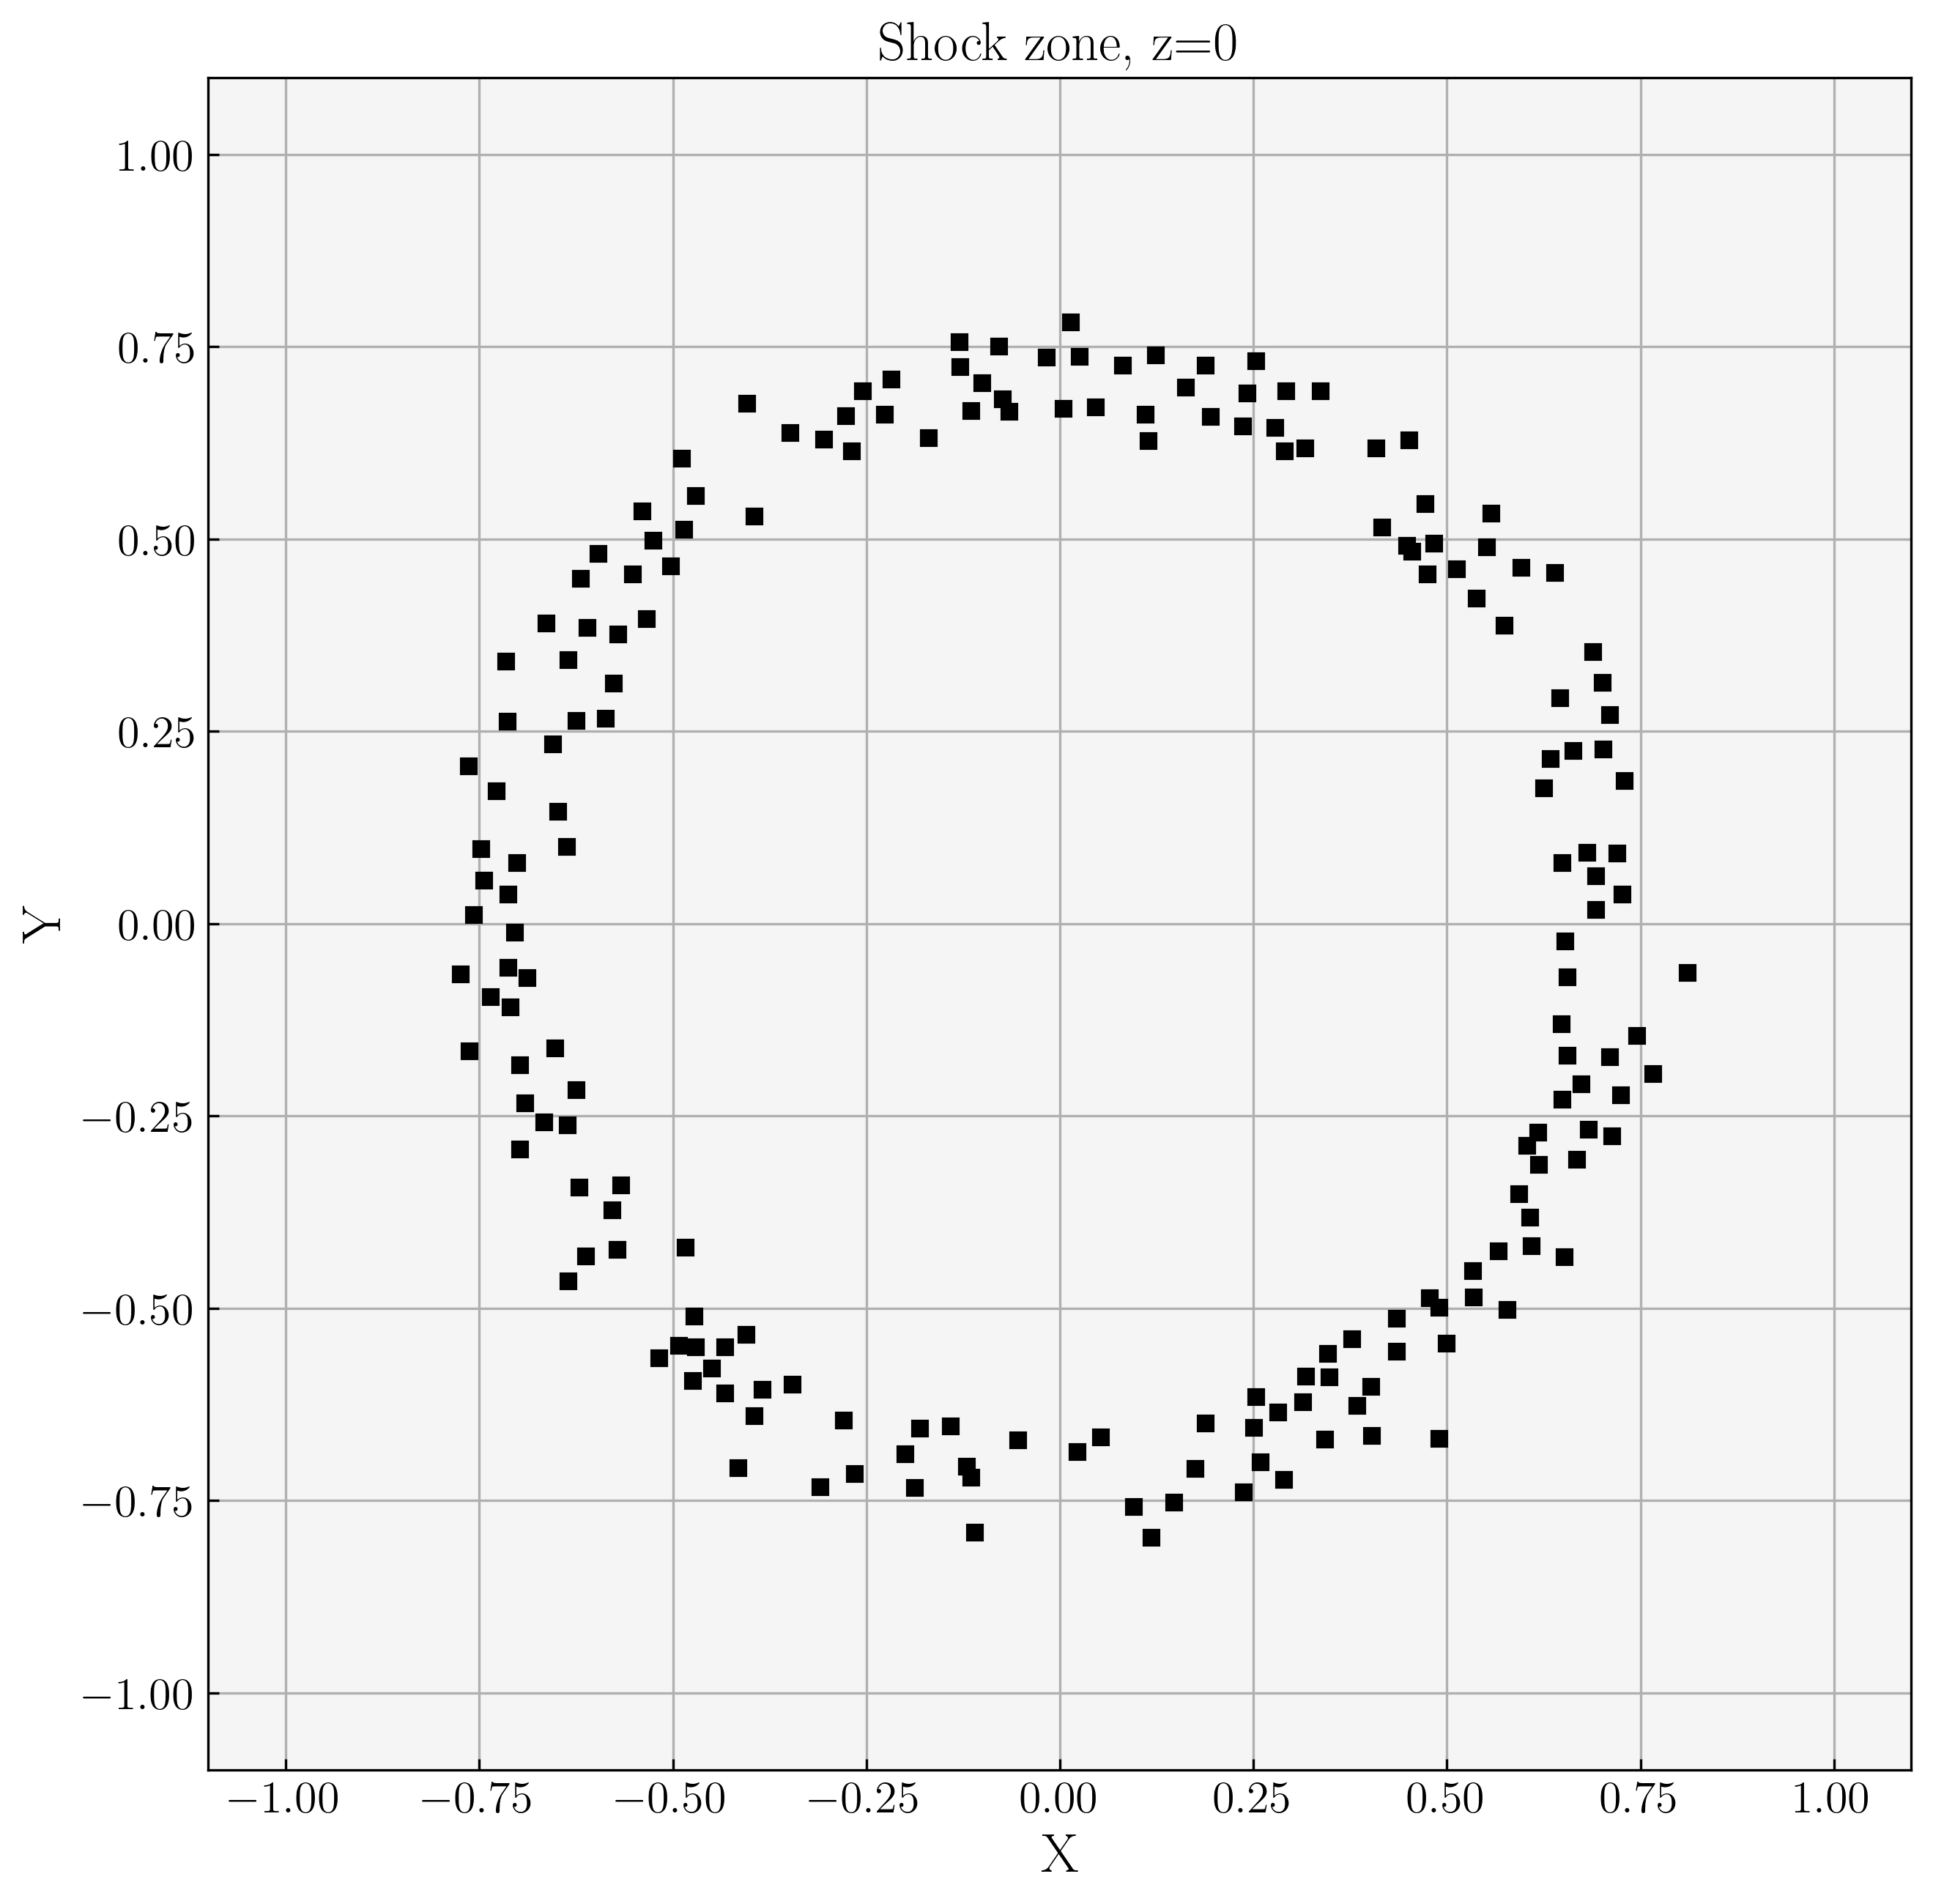

In [28]:
if folder == 'sedov':
    plt.figure(figsize=(10,10))
    plt.plot(X_shock[np.abs(Z_shock)<0.02], Y_shock[np.abs(Z_shock)<0.02], 'ks', c = 'k', markerfacecolor='k', ms=5, markeredgecolor='k')
    plt.xlabel('X', fontsize = 18)
    plt.ylabel('Y', fontsize = 18)
    plt.grid()
    plt.title('Shock zone, z=0', fontsize = 18)
    plt.xlim(-1.1,1.1)
    plt.ylim(-1.1,1.1)
    if save == True: 
        plt.savefig(f'Figs/{snap}/shockzone_{snap}.png')
    plt.show()

if folder == 'TDE':
    x = X_shock #data[0]
    y = Y_shock #data[1]
    plt.figure(figsize=(10,7))
    img = plt.scatter(X[::500]/20_000, Y[::500]/20_000, c = np.log10(Temp[::500]), alpha = 0.5, vmin = 2, vmax = 8)
    cbar = plt.colorbar(img)
    cbar.set_label(r'$\log_{10}$Temperature', fontsize = 18)
    plt.plot(x/20_000, y/20_000, 'ks',  markerfacecolor='none', ms=5, markeredgecolor='k', label = 'shock zone')
    plt.xlabel(r'X [x/$R_a$]', fontsize = 18)
    plt.ylabel(r'Y [x/$R_a$]', fontsize = 18)
    plt.ylim(-0.3, 0.2)
    plt.xlim(-1,0.05)
    plt.grid()
    plt.title(r't/$t_{t_{fb}}$=0.5', fontsize = 18)
    if save:
        plt.savefig(f'Figs/shockzone_{snap}.png')
    plt.show()

/var/folders/s6/3n46ppqn3jx7765w8c686c740000gn/T/ipykernel_69547/3563922277.py:7: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "ks" (-> color='k'). The keyword argument will take precedence.
  plt.plot(X_shock, Y_shock, 'ks', c = 'k', markerfacecolor='none', ms=5, markeredgecolor='k', label = 'shock zone')


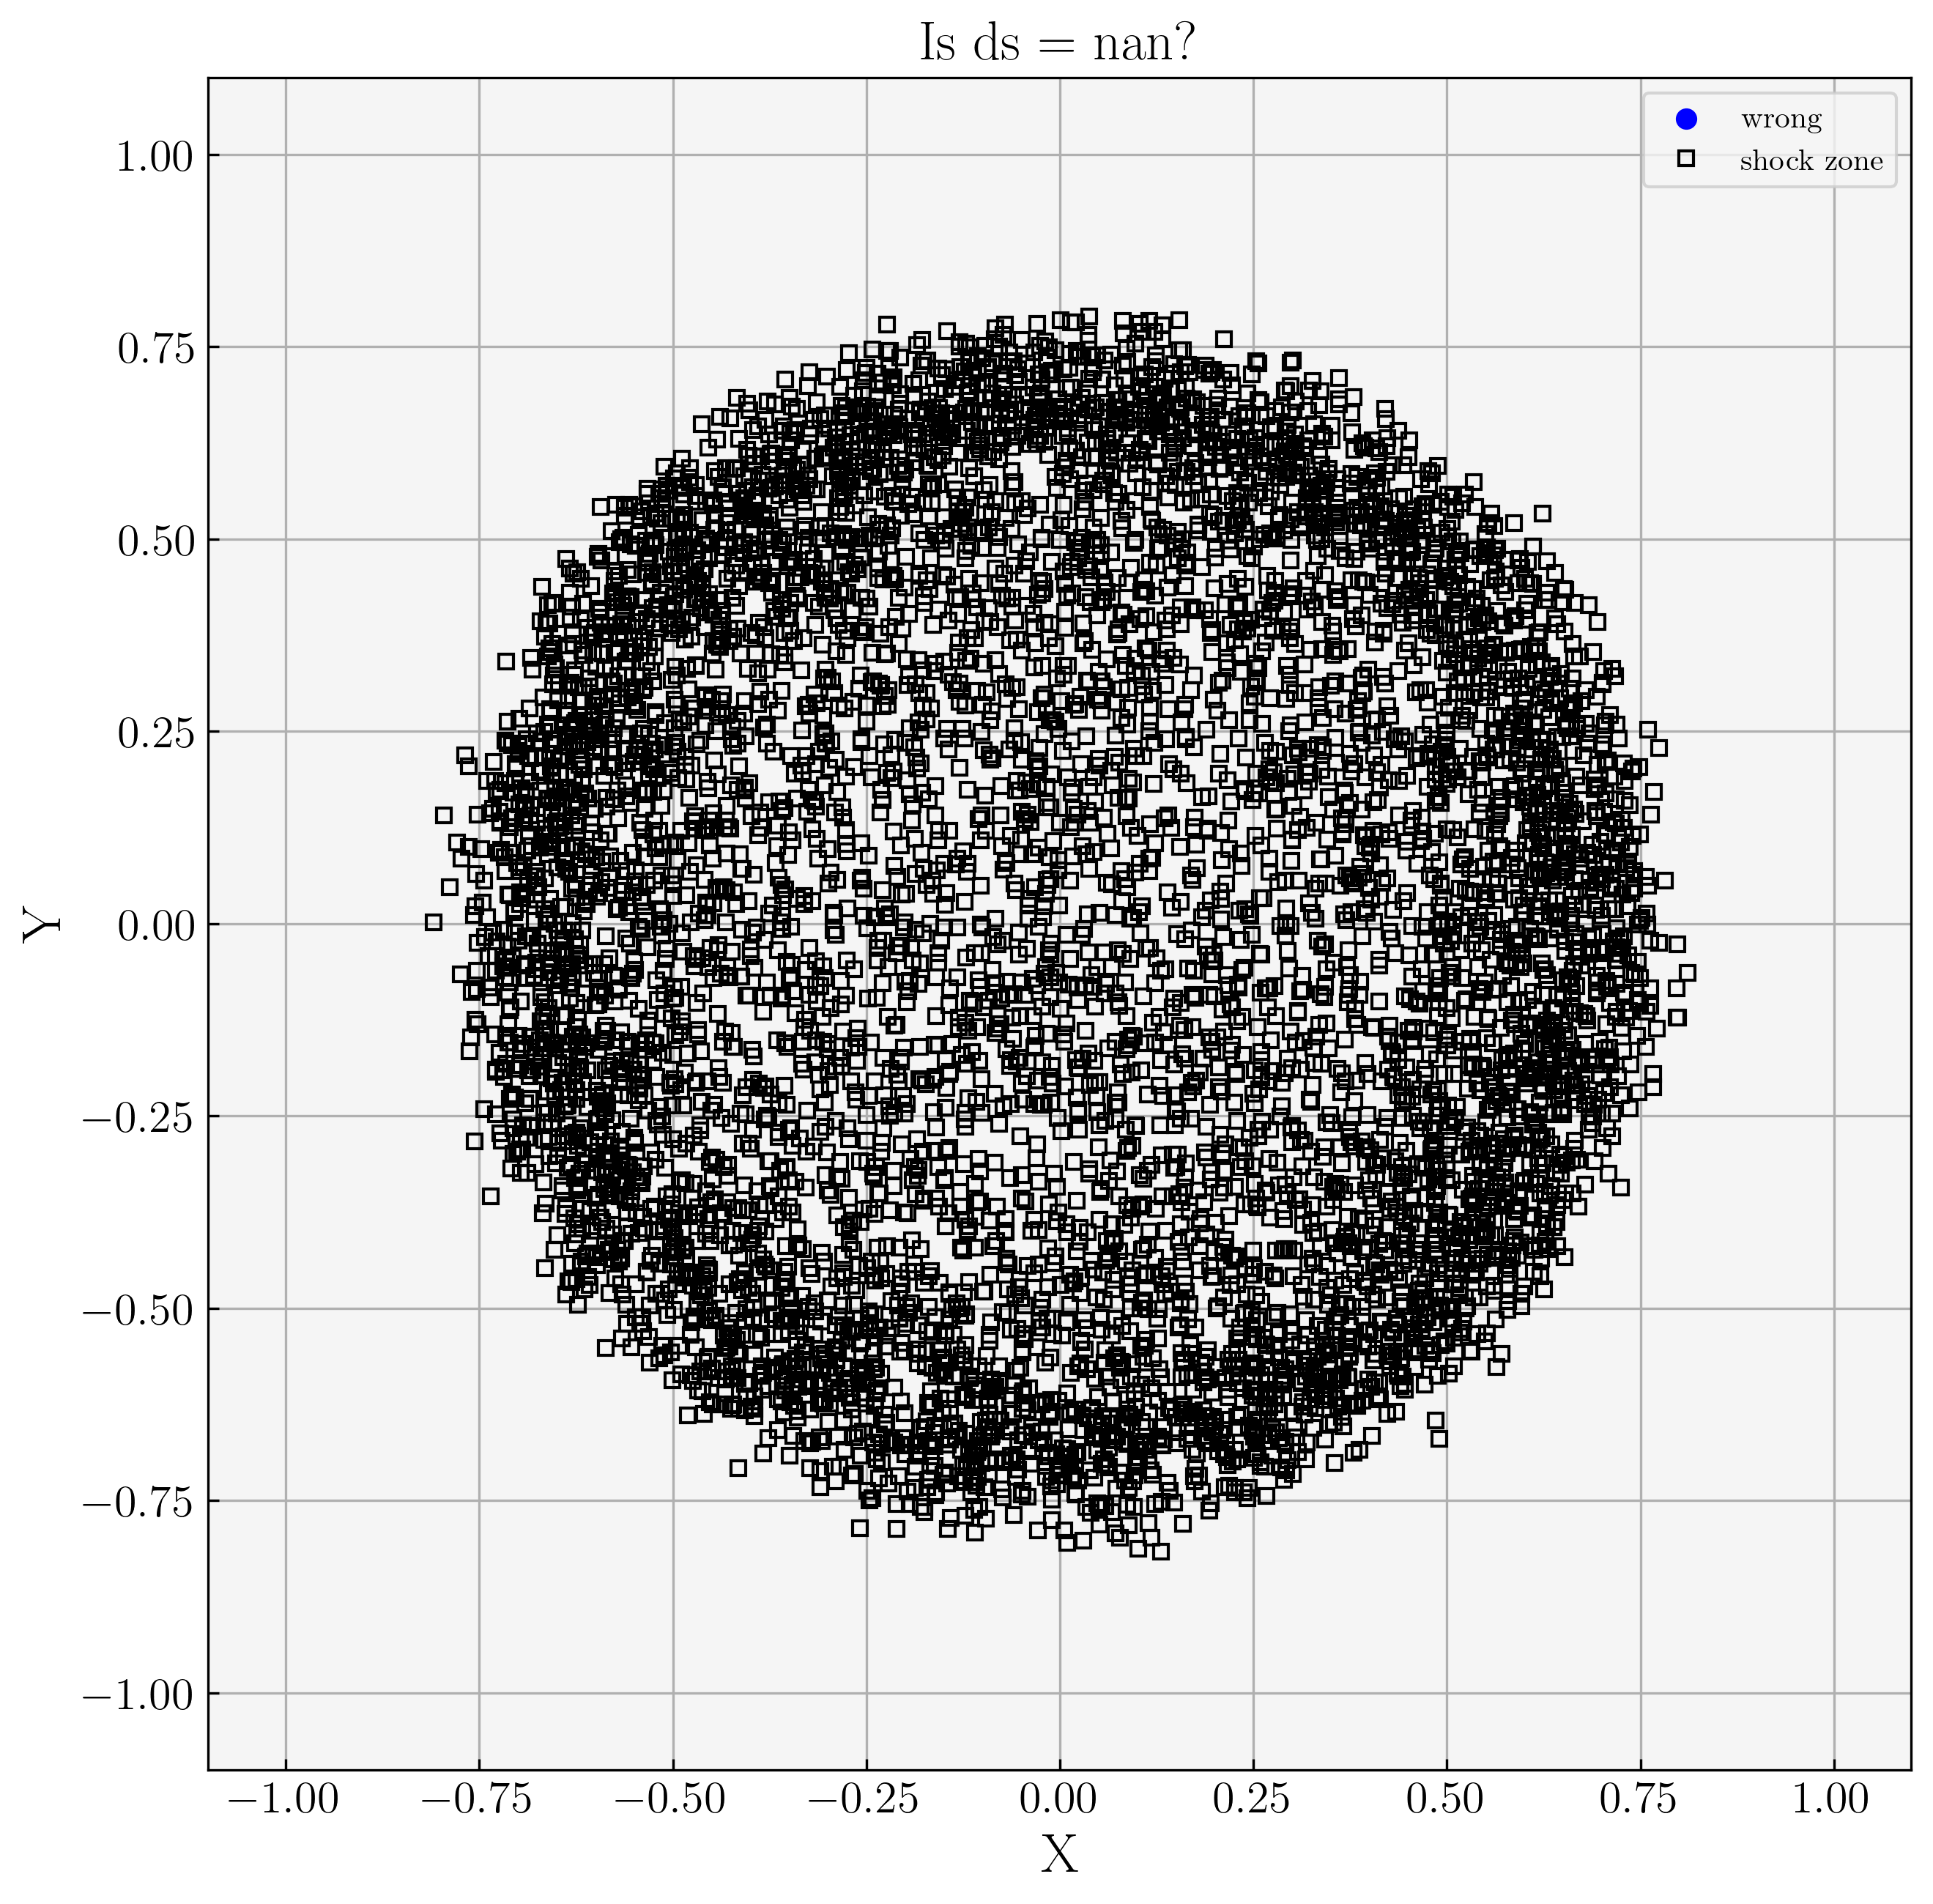

In [29]:
x_who = np.array(x_who)
y_who = np.array(y_who)
z_who = np.array(z_who)

plt.figure(figsize=(10,10))
plt.scatter(x_who, y_who,  c = 'b', label = 'wrong')
plt.plot(X_shock, Y_shock, 'ks', c = 'k', markerfacecolor='none', ms=5, markeredgecolor='k', label = 'shock zone')
plt.xlim(-1.1,1.1)
plt.ylim(-1.1,1.1)
plt.xlabel('X', fontsize = 18)
plt.ylabel('Y', fontsize = 18)
plt.legend()
plt.grid()
plt.title(r'Is ds = nan?', fontsize = 18)
plt.legend()
if save:
    plt.savefig(f'Figs/{snap}/4who_{snap}.png')
plt.show()